In [26]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import svm
from scipy import io, stats, cluster, ndimage
import math
import pandas as pd

# import learners

# 3 Wine Classification

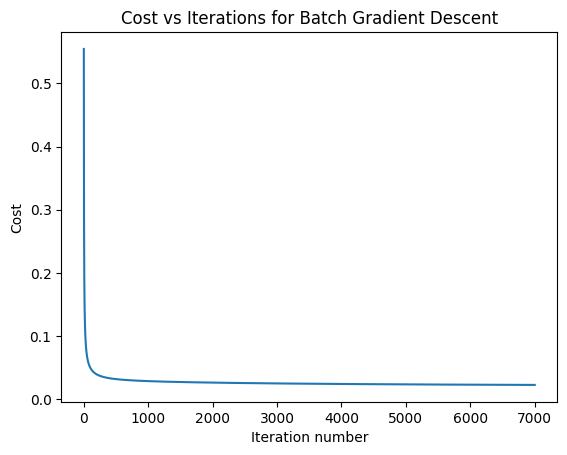

Validation Accuracy is 99.5 %


In [127]:
# 3.2
np.random.seed(10)

wine_data = io.loadmat('data.mat')
# dict_keys(['__header__', '__version__', '__globals__', 'y', 'X', 'description', 'X_test'])

wine_X = wine_data['X'] 
wine_y = wine_data['y'] # len = 5000
num_feat = len(wine_data["X"][0]) # len = 12 


# Add fictitious feature of 1s for bias term
assert len(wine_X) == len(wine_y)
num_samples = len(wine_X)
fict_feat = np.ones((num_samples, 1))  # [[1], [1], ...]
wine_X = np.append(wine_X, fict_feat, axis=1)
num_feat_add_1 = num_feat + 1

# train val split
shuffled_idx = np.random.permutation(num_samples)
val_size = 1000 
val_data = wine_X[shuffled_idx][:val_size]
val_label = wine_y[shuffled_idx][:val_size]

train_data = wine_X[shuffled_idx][val_size:]
train_label = wine_y[shuffled_idx][val_size:]
train_label = train_label.flatten()

# Normalizing data by using means and sds of training data
means = [np.mean(train_data[:, i]) for i in range(num_feat)]
sds = [np.std(train_data[:, i]) for i in range(num_feat)]

# standardize each feature across all samples -> for trainning data
for i in range(num_feat): 
    train_data[:, i] = (train_data[:, i] - means[i]) / sds[i]

# for validation data
for i in range(num_feat):
    val_data[:, i] = (val_data[:, i] - means[i]) / sds[i]


def logis(w, X):
    z = np.dot(X, w)  # Vectorized computation of the dot product
    s = 1 / (1 + np.exp(-z))  # Vectorized application of the sigmoid function
    return s

# Initialize the weights with an additional term for the bias
w = np.zeros(num_feat + 1)

# Set learning rate, regularization constant, iterations
learn_rate = 0.0001
reg_const = 0.05
num_iter = 7000

# Init a list to keep track of the cost at each iteration
cost = np.zeros(num_iter + 1)

# Compute the initial cost
probabilities = logis(w, train_data)
cost[0] = (
    -np.dot(train_label.T, np.log(probabilities))
    - np.dot((1 - train_label.T), np.log(1 - probabilities))
    + (reg_const / 2) * np.sum(w**2)
) / num_samples

# Perform gradient descent
for iter in range(num_iter):
    
    # Calculate the gradient
    errors = train_label - probabilities
    gradient = reg_const*w - np.dot(train_data.T, errors)

    # Update the weights
    w -= learn_rate * gradient

    # Calculate the predictions
    probabilities = logis(w, train_data)

    # Calculate and store the cost
    cost[iter + 1] = (
        -np.dot(train_label.T, np.log(probabilities))
        - np.dot((1 - train_label.T), np.log(1 - probabilities))
        + (reg_const / 2) * np.sum(w**2)
    ) / num_samples

# Plot the cost history over iterations
plt.plot(cost)
plt.xlabel("Iteration number")
plt.ylabel("Cost")
plt.title("Cost vs Iterations for Batch Gradient Descent")
plt.show()


# check validation
s_test = logis(w, val_data)

# Convert probabilities to binary predictions
binary_predictions = np.where(s_test >= 0.5, 1, 0)

correct_predictions = np.sum(binary_predictions == val_label.flatten())

# Calculate accuracy
accur = (
    correct_predictions / val_size
)  

print(f"Validation Accuracy is {accur * 100} %")

In [128]:
# 3.6 Kaggle Submission

fict_feat_test = np.ones((len(wine_data["X_test"]), 1))  # [[1], [1], ...]
wine_X_test = np.append(wine_data["X_test"], fict_feat_test, axis=1)
for i in range(num_feat):
    wine_X_test[:, i] = (wine_X_test[:, i] - means[i]) / sds[i]


predictions = logis(w, wine_X_test)

# Convert probabilities to binary predictions
predictions = np.where(predictions >= 0.5, 1, 0)

df = pd.DataFrame({"Category": predictions})
df.index += 1
df.to_csv(f"wine_pred.csv", index_label="Id")

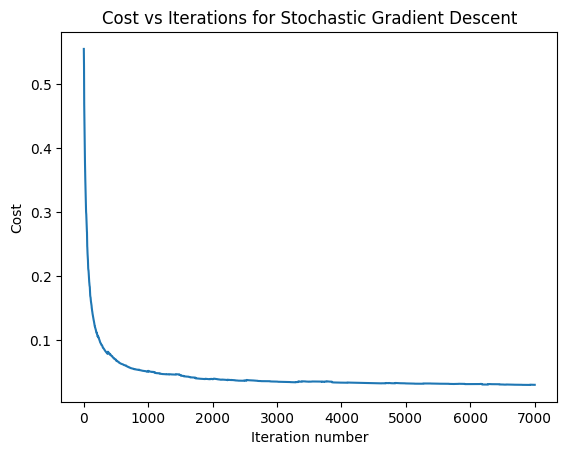

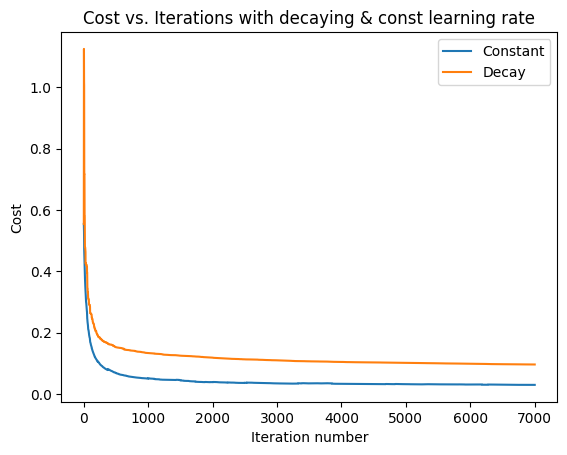

Validation Accuracy is 99.3 %
Validation Accuracy is 95.19999999999999 %


In [121]:
# 3.4

np.random.seed(10)

wine_data = io.loadmat("data.mat")
# dict_keys(['__header__', '__version__', '__globals__', 'y', 'X', 'description', 'X_test'])

wine_X = wine_data["X"]
wine_y = wine_data["y"]  # len = 5000
num_feat = len(wine_data["X"][0])  # len = 12


# Add fictitious feature of 1s for bias term
assert len(wine_X) == len(wine_y)
num_samples = len(wine_X)
fict_feat = np.ones((num_samples, 1))  # [[1], [1], ...]
wine_X = np.append(wine_X, fict_feat, axis=1)
num_feat_add_1 = num_feat + 1

# train val split
shuffled_idx = np.random.permutation(num_samples)
val_size = 1000
val_data = wine_X[shuffled_idx][:val_size]
val_label = wine_y[shuffled_idx][:val_size]

train_data = wine_X[shuffled_idx][val_size:]
train_label = wine_y[shuffled_idx][val_size:]
train_label = train_label.flatten()

# Normalizing data by using means and sds of training data
means = [np.mean(train_data[:, i]) for i in range(num_feat)]
sds = [np.std(train_data[:, i]) for i in range(num_feat)]

# standardize each feature across all samples -> for trainning data
for i in range(num_feat):
    train_data[:, i] = (train_data[:, i] - means[i]) / sds[i]

# for validation data
for i in range(num_feat):
    val_data[:, i] = (val_data[:, i] - means[i]) / sds[i]


def logis(w, X):
    z = np.dot(X, w)  # Vectorized computation of the dot product
    s = 1 / (1 + np.exp(-z))  # Vectorized application of the sigmoid function
    return s


# Initialize the weights, grad, cost for const and proportional step sizes
w = np.zeros(num_feat + 1)
grad = np.zeros(num_feat + 1)
w_p= np.zeros(num_feat + 1)
grad_p = np.zeros(num_feat + 1)


# Set learning rate, regularization constant, iterations
learn_rate = 0.00001
learn_rate_init = 0.0005
reg_const = 0.01
num_iter = 7000

cost = np.zeros(num_iter + 1)
cost_p = np.zeros(num_iter + 1)

prob = logis(w, train_data)
prob_p = logis(w_p, train_data)


cost[0] = (
    -np.dot(train_label.T, np.log(prob))
    - np.dot((1 - train_label.T), np.log(1 - prob))
    + (reg_const / 2) * np.sum(w**2)
) / num_samples

cost_p[0] = (
    -np.dot(train_label.T, np.log(prob_p))
    - np.dot((1 - train_label.T), np.log(1 - prob_p))
    + (reg_const / 2) * np.sum(w_p**2)
) / num_samples

train_size = num_samples - val_size
index = -1


for iter in range(num_iter):
    learn_rate_p = np.true_divide(learn_rate_init, iter + 1)
    index += 1

    # # if finish a cycle, reshuffle
    if index == train_size:
        shuffled_idx = np.random.permutation(train_size)
        train_data = train_data[shuffled_idx]
        train_label = train_label[shuffled_idx]
        index = 0

    # Calculate the gradient
    errors = train_label - prob
    errors_p = train_label - prob_p

    gradient = reg_const * w - train_size * errors[index] * train_data[index].T
    gradient_p = reg_const * w_p - train_size * errors_p[index] * train_data[index].T

    # Update the weights
    w -= learn_rate * gradient
    w_p -= learn_rate_p * gradient_p

    prob = logis(w, train_data)
    prob_p = logis(w_p, train_data)

    # Calculate and store the cost
    cost[iter + 1] = (
        - np.dot(train_label.T, np.log(prob))
        - np.dot((1 - train_label.T), np.log(1 - prob))
        + (reg_const / 2) * np.sum(w**2)
    ) / num_samples

    cost_p[iter + 1] = (
        - np.dot(train_label.T, np.log(prob_p))
        - np.dot((1 - train_label.T), np.log(1 - prob_p))
        + (reg_const / 2) * np.sum(w_p**2)
    ) / num_samples

# Plot the cost history over iterations
plt.plot(cost)
plt.xlabel("Iteration number")
plt.ylabel("Cost")
plt.title("Cost vs Iterations for Stochastic Gradient Descent")
plt.show()

# plt.plot(cost, label="no decay")
plt.plot(cost, label="Constant")
plt.plot(cost_p, label="Decay")
plt.xlabel("Iteration number")
plt.ylabel("Cost")
plt.legend()
plt.title("Cost vs. Iterations with decaying & const learning rate")
plt.show()


# Checking validation
s_test = logis(w, val_data)
s_test_p = logis(w_p, val_data)

# Convert probabilities to binary predictions
binary_predictions = np.where(s_test >= 0.5, 1, 0)
correct_predictions = np.sum(binary_predictions == val_label.flatten())

binary_predictions_p = np.where(s_test_p >= 0.5, 1, 0)
correct_predictions_p = np.sum(binary_predictions_p == val_label.flatten())

# Calculate accuracy
accur = correct_predictions / val_size
accur_p = correct_predictions_p / val_size

print(f"Validation Accuracy is {accur * 100} %")
print(f"Validation Accuracy is {accur_p * 100} %")

\pagebreak

# 5.1

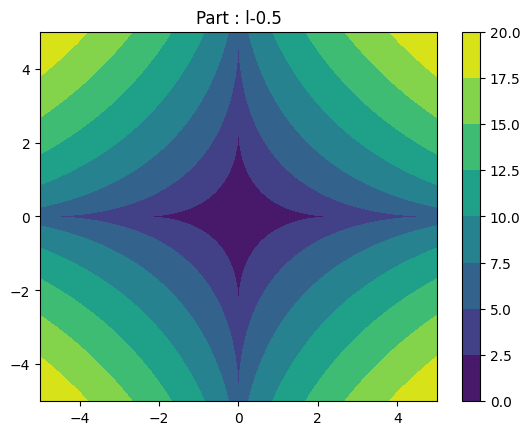

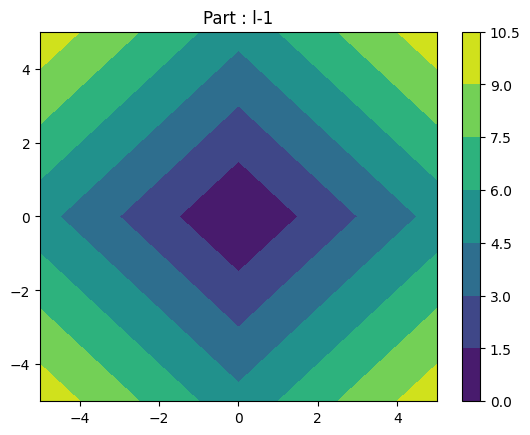

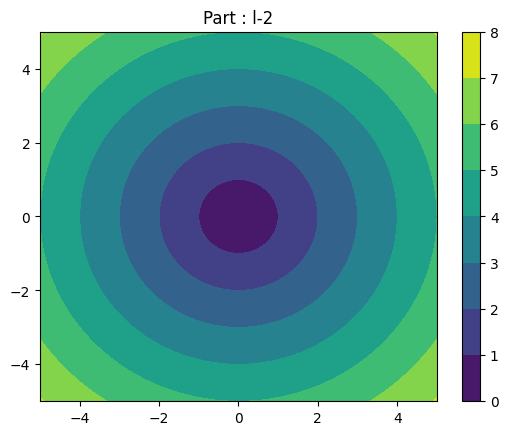

In [136]:
def lp_norm(w1, w2, p): 
  return (np.abs(w1)**p + np.abs(w2)**p) ** (1/p)

x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

# Part a
Z = lp_norm(X, Y, 0.5)
plt.title(f"Part : l-0.5") 
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

# Part b
Z = lp_norm(X, Y, 1)
plt.title(f"Part : l-1")
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

# Part c
Z = lp_norm(X, Y, 2)
plt.title(f"Part : l-2")
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()